# **Cardiovascular Disease Predictor**
*Rohan Shah*

# Part 1: Introduction

I chose to discover the various health factors that most evidently are correlated with a positive case of Cardiovascular Disease. Going into the project, I intended to see how factors such as diet, exercise, health history, and even demographics can all be potential predictors of heart disease, which led me to want to build a model that would predict whether or not the person is at risk for heart disease with reasonable levels of sensitivity and specificity.

I used a dataset with a preselected set of variables specifically relevant to heart disease, and all of the data used has been taken from the Behavioral Risk Factor Surveillance System from 2021. Using the data presented, I sought to specifically view the data in comparison to the diagnosis of heart disease per patient, and then draw conclusions from there. I also utilized a dataset with additional numerical variables relevant from heart disease taken from the Behavioral Risk Factor Surveillance System from 2015.

The results are below, along with various takeaways, methodologies used to gather my findings, and conclusions after each section. Enjoy!

# Part 2: Data Loading

In [ ]:
# imports necessary for project
!pip install kaggle
!pip install pandasql
!pip install sqlalchemy==1.4.46
!pip install imbalanced-learn
!pip install plotly

import pandas as pd
import pandasql as psql
import plotly.express as px
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import classification_report

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=6455894584f8ee608f74cb0f34e733de13534c17a84ef05ea37a6fa9613b30dd
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.


## Loading & Analyzing Data


In [ ]:
# Mounting google drive in order to access Kaggle data set
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory (only run when restarting kernal!)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download datasets
!!kaggle datasets download -d alphiree/cardiovascular-diseases-risk-prediction-dataset
!!kaggle datasets download -d alexteboul/heart-disease-health-indicators-dataset

['Downloading heart-disease-health-indicators-dataset.zip to /content',
 '',
 '  0% 0.00/2.66M [00:00<?, ?B/s]',
 '',
 '100% 2.66M/2.66M [00:00<00:00, 75.5MB/s]']

In [ ]:
# Unzip folders in Colab content folder
!unzip /content/cardiovascular-diseases-risk-prediction-dataset.zip
!unzip /content/heart-disease-health-indicators-dataset.zip

Archive:  /content/cardiovascular-diseases-risk-prediction-dataset.zip
  inflating: CVD_cleaned.csv         
Archive:  /content/heart-disease-health-indicators-dataset.zip
  inflating: heart_disease_health_indicators_BRFSS2015.csv  


In [ ]:
# Read the csv files and save them to dataframes called "BRFSS_2021" and "BRFSS_2015"
BRFSS_2021 = pd.read_csv('CVD_cleaned.csv')
BRFSS_2015 = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
original = BRFSS_2021.copy()

#Part 3: Exploratory Data Analysis and Visualization

In [ ]:
#explore top few columns of datasets
BRFSS_2021.head(10)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0
5,Good,Within the past year,No,No,No,No,Yes,No,Yes,Male,60-64,183.0,154.22,46.11,No,0.0,12.0,12.0,12.0
6,Fair,Within the past year,Yes,Yes,No,No,No,No,Yes,Male,60-64,175.0,69.85,22.74,Yes,0.0,16.0,8.0,0.0
7,Good,Within the past year,Yes,No,No,No,No,No,Yes,Female,65-69,165.0,108.86,39.94,Yes,3.0,30.0,8.0,8.0
8,Fair,Within the past year,No,No,No,No,Yes,No,No,Female,65-69,163.0,72.57,27.46,Yes,0.0,12.0,12.0,4.0
9,Fair,Within the past year,No,No,No,No,No,Yes,Yes,Female,70-74,163.0,91.63,34.67,No,0.0,12.0,12.0,1.0


In [ ]:
BRFSS_2015.head(10)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,1.0,1.0,1.0,1.0,30.0,1.0,0.0,2.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


In [ ]:
# datatypes & details of our datasets
BRFSS_2021.dtypes

General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
dtype: object

In [ ]:
BRFSS_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

In [ ]:
BRFSS_2021.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


In [ ]:
BRFSS_2015.dtypes

HeartDiseaseorAttack    float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
Diabetes                float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

In [ ]:
BRFSS_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
BRFSS_2015.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.296921,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.292087,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.698160,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [ ]:
#check for null values
nulls = BRFSS_2021.isnull().sum()
print(nulls)

General_Health                  0
Checkup                         0
Exercise                        0
Heart_Disease                   0
Skin_Cancer                     0
Other_Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age_Category                    0
Height_(cm)                     0
Weight_(kg)                     0
BMI                             0
Smoking_History                 0
Alcohol_Consumption             0
Fruit_Consumption               0
Green_Vegetables_Consumption    0
FriedPotato_Consumption         0
dtype: int64


In [ ]:
#check for null values
nulls = BRFSS_2015.isnull().sum()
print(nulls)

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [ ]:
#inspect all non-numeric columns to figure out how to deal with them
for column in BRFSS_2021.columns:
  if BRFSS_2021[column].dtype == "object":
    print(BRFSS_2021[column].unique())

['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']
['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']
['Yes' 'No']
['Female' 'Male']
['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']
['Yes' 'No']


In [ ]:
#apply SQL queries to encode categorical variables
query_general_health = """
SELECT
  CASE
    WHEN General_Health = 'Poor' THEN 0
    WHEN General_Health = 'Fair' THEN 1
    WHEN General_Health = 'Good' THEN 2
    WHEN General_Health = 'Very Good' THEN 3
    WHEN General_Health = 'Excellent' THEN 4
  END as General_Health
FROM BRFSS_2021;
"""

In [ ]:
query_checkup = """
SELECT
  CASE
    WHEN Checkup = 'Within the past year' THEN 0
    WHEN Checkup = 'Within the past 2 years' THEN 1
    WHEN Checkup = 'Within the past 5 years' THEN 2
    WHEN Checkup = '5 or more years ago' THEN 3
    WHEN Checkup = 'Never' THEN 4
  END as Checkup
FROM BRFSS_2021;
"""

In [ ]:
query_exercise = """
SELECT
  CASE
    WHEN Exercise = 'No' THEN 0
    WHEN Exercise = 'Yes' THEN 1
  END as Exercise
FROM BRFSS_2021;
"""

In [ ]:
query_heart_disease = """
SELECT
  CASE
    WHEN Heart_Disease = 'No' THEN 0
    WHEN Heart_Disease = 'Yes' THEN 1
  END as Heart_Disease
FROM BRFSS_2021;
"""

In [ ]:
query_skin_cancer = """
SELECT
  CASE
    WHEN Skin_Cancer = 'No' THEN 0
    WHEN Skin_Cancer = 'Yes' THEN 1
  END as Skin_Cancer
FROM BRFSS_2021;
"""

In [ ]:
query_other_cancer = """
SELECT
  CASE
    WHEN Other_Cancer = 'No' THEN 0
    WHEN Other_Cancer = 'Yes' THEN 1
  END as Other_Cancer
FROM BRFSS_2021;
"""

In [ ]:
query_depression = """
SELECT
  CASE
    WHEN Depression = 'No' THEN 0
    WHEN Depression = 'Yes' THEN 1
  END as Depression
FROM BRFSS_2021;
"""

In [ ]:
query_diabetes = """
SELECT
  CASE
    WHEN Diabetes = 'No' THEN 0
    WHEN Diabetes = 'No, pre-diabetes or borderline diabetes' THEN 1
    WHEN Diabetes = 'Yes, but female told only during pregnancy' THEN 2
    WHEN Diabetes = 'Yes' THEN 3
  END as Diabetes
FROM BRFSS_2021;
"""

In [ ]:
query_arthritis = """
SELECT
  CASE
    WHEN Arthritis = 'No' THEN 0
    WHEN Arthritis = 'Yes' THEN 1
  END as Arthritis
FROM BRFSS_2021;
"""

In [ ]:
query_sex = """
SELECT
  CASE
    WHEN Sex = 'Female' THEN 0
    WHEN Sex = 'Male' THEN 1
  END as Sex
FROM BRFSS_2021;
"""

In [ ]:
query_age_category = """
SELECT
  CASE
    WHEN Age_Category = '18-24' THEN 0
    WHEN Age_Category = '25-29' THEN 1
    WHEN Age_Category = '30-34' THEN 2
    WHEN Age_Category = '35-39' THEN 3
    WHEN Age_Category = '40-44' THEN 4
    WHEN Age_Category = '45-49' THEN 5
    WHEN Age_Category = '50-54' THEN 6
    WHEN Age_Category = '55-59' THEN 7
    WHEN Age_Category = '60-64' THEN 8
    WHEN Age_Category = '65-69' THEN 9
    WHEN Age_Category = '70-74' THEN 10
    WHEN Age_Category = '75-79' THEN 11
    WHEN Age_Category = '80+' THEN 12
  END as Age_Category
FROM BRFSS_2021;
"""

In [ ]:
query_smoking_history = """
SELECT
  CASE
    WHEN Smoking_History = 'No' THEN 0
    WHEN Smoking_History = 'Yes' THEN 1
  END as Smoking_History
FROM BRFSS_2021;
"""

In [ ]:
query_diet = """
SELECT
  (Fruit_Consumption + Green_Vegetables_Consumption - FriedPotato_Consumption)
  as Diet
FROM BRFSS_2021;
"""

In [ ]:
# putting each of these individual queries into dataframes
df_general_health = psql.sqldf(query_general_health, locals())
df_checkup = psql.sqldf(query_checkup, locals())
df_exercise = psql.sqldf(query_exercise, locals())
df_heart_disease = psql.sqldf(query_heart_disease, locals())
df_skin_cancer = psql.sqldf(query_skin_cancer, locals())
df_other_cancer = psql.sqldf(query_other_cancer, locals())
df_depression = psql.sqldf(query_depression, locals())
df_diabetes = psql.sqldf(query_diabetes, locals())
df_arthritis = psql.sqldf(query_arthritis, locals())
df_sex = psql.sqldf(query_sex, locals())
df_age_category = psql.sqldf(query_age_category, locals())
df_smoking_history = psql.sqldf(query_smoking_history, locals())
df_diet = psql.sqldf(query_diet, locals())

In [ ]:
# concatting our dataframes back into BRFSS_2021
BRFSS_2021 = pd.concat([
    df_general_health,
    df_checkup,
    df_exercise,
    df_heart_disease,
    df_skin_cancer,
    df_other_cancer,
    df_depression,
    df_diabetes,
    df_arthritis,
    df_sex,
    df_age_category,
    df_smoking_history,
    df_diet,
    BRFSS_2021[["Height_(cm)","Weight_(kg)","BMI","Alcohol_Consumption"]]
], axis=1)

In [ ]:
#our new dataframe
BRFSS_2021.head(10)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Smoking_History,Diet,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption
0,0,1,0,0,0,0,0,0,1,0,10,1,34.0,150.0,32.66,14.54,0.0
1,3,0,0,1,0,0,0,3,0,0,10,0,26.0,165.0,77.11,28.29,0.0
2,3,0,1,0,0,0,0,3,0,0,8,0,-1.0,163.0,88.45,33.47,4.0
3,0,0,1,1,0,0,0,3,0,1,11,0,52.0,180.0,93.44,28.73,0.0
4,2,0,0,0,0,0,0,0,0,1,12,1,12.0,191.0,88.45,24.37,0.0
5,2,0,0,0,0,0,1,0,1,1,8,0,12.0,183.0,154.22,46.11,0.0
6,1,0,1,1,0,0,0,0,1,1,8,1,24.0,175.0,69.85,22.74,0.0
7,2,0,1,0,0,0,0,0,1,0,9,1,30.0,165.0,108.86,39.94,3.0
8,1,0,0,0,0,0,1,0,0,0,9,1,20.0,163.0,72.57,27.46,0.0
9,1,0,0,0,0,0,0,3,1,0,10,0,23.0,163.0,91.63,34.67,0.0


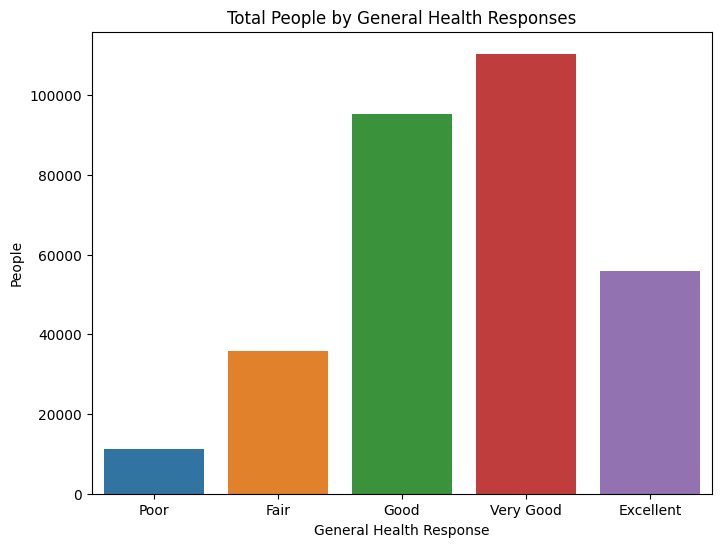

In [ ]:
# count plot of general health numbers - gives us a sense of initial questioning

plt.figure(figsize=(8, 6))
sns.countplot(data=BRFSS_2021, x='General_Health')
plt.title('Total People by General Health Responses')
plt.xlabel('General Health Response')
plt.ylabel('People')

health_types = {
    '0': 'Poor',
    '1': 'Fair',
    '2': 'Good',
    '3': 'Very Good',
    '4': 'Excellent'
}

plt.xticks(ticks=range(len(health_types)), labels=list(health_types.values()))
plt.show()

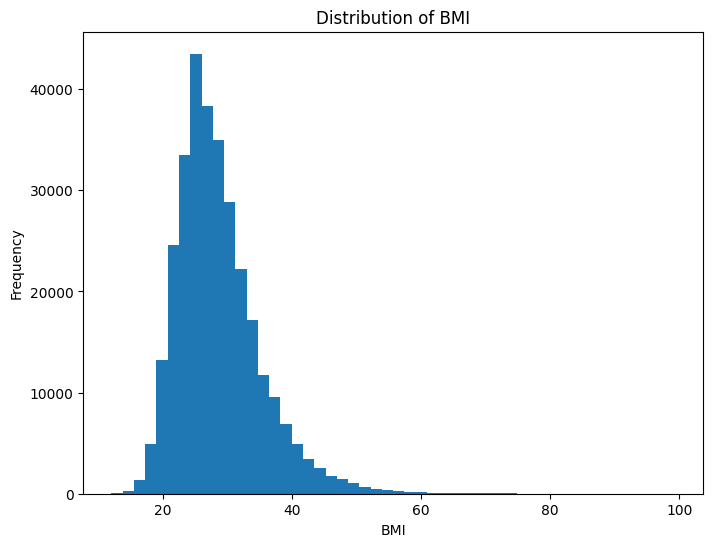

In [ ]:
# histogram of bmi distribution of dataset

plt.figure(figsize=(8, 6))
plt.hist(BRFSS_2021['BMI'], bins=50)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

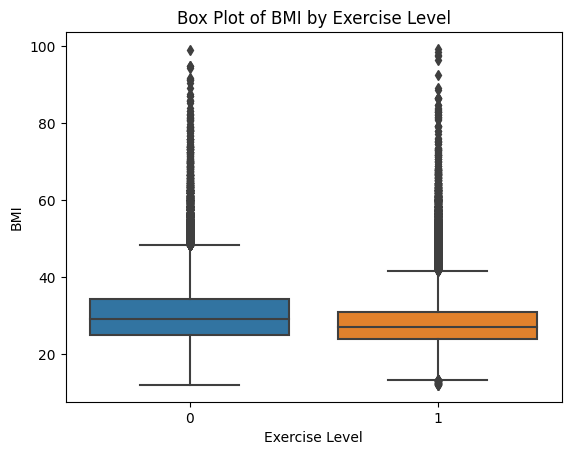

In [ ]:
# box plot measuring relationship between BMI values and reported exercise

sns.boxplot(x='Exercise', y='BMI', data=BRFSS_2021)
plt.title('Box Plot of BMI by Exercise Level')
plt.xlabel('Exercise Level')
plt.ylabel('BMI')
plt.show()

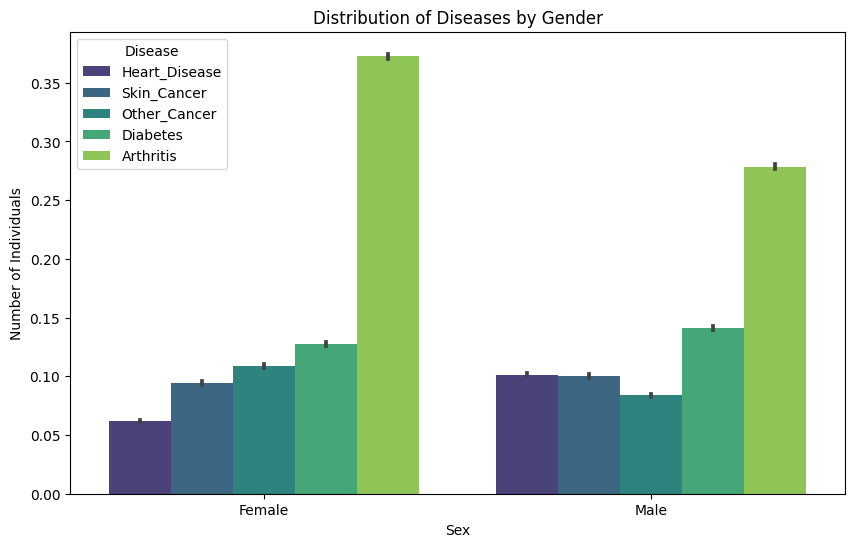

In [ ]:
# barplot of various disease distribution amongst users split by gender

disease_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Diabetes', 'Arthritis']
original[disease_columns] = original[disease_columns].apply(lambda x: x.map({'Yes': 1, 'No': 0}))
df_melted = pd.melt(original, id_vars='Sex', value_vars=disease_columns, var_name='Disease', value_name='Affected')
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Affected', hue='Disease', data=df_melted, palette='viridis')
plt.title('Distribution of Diseases by Gender')
plt.ylabel('Number of Individuals')
plt.show()

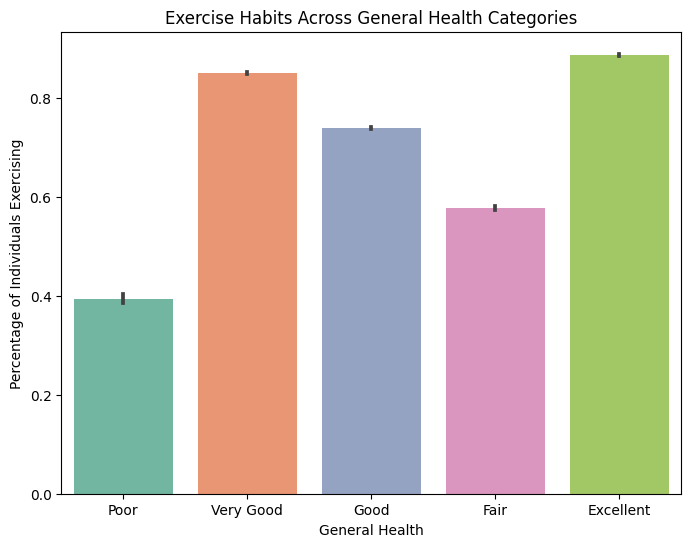

In [ ]:
# barplot comparing exercise habits to reports of general health

original['Exercise'] = original['Exercise'].map({'Yes': 1, 'No': 0})
plt.figure(figsize=(8, 6))
sns.barplot(x='General_Health', y='Exercise', data=original, palette='Set2')
plt.title('Exercise Habits Across General Health Categories')
plt.ylabel('Percentage of Individuals Exercising')
plt.xlabel('General Health')
plt.show()

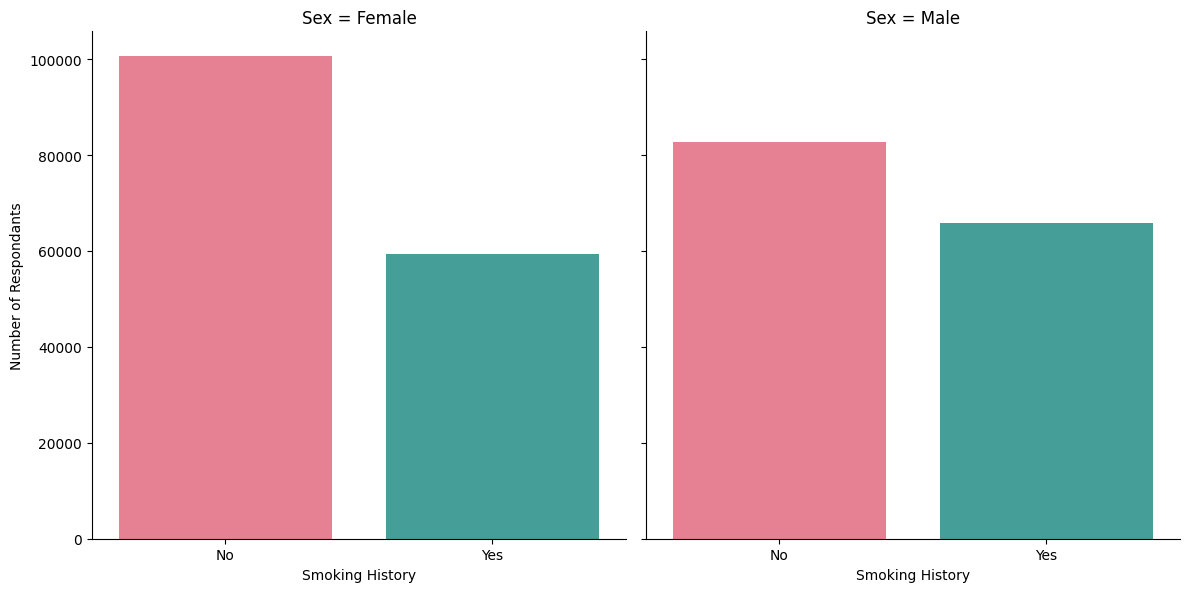

In [ ]:
# breakdown of smoking history answers split by gender, represented through FacetGrid

g = sns.FacetGrid(BRFSS_2021, col='Sex', height=6)
order = BRFSS_2021['Smoking_History'].value_counts().index
g.map(sns.countplot, 'Smoking_History', palette='husl', order=order)

g.set_axis_labels('Smoking History', 'Number of Respondants')
g.set_xticklabels(labels=['No', 'Yes'])

g.set_titles(col_template="{col_name}")
g.axes[0, 0].set_title("Sex = Female")
g.axes[0, 1].set_title("Sex = Male")
plt.show()

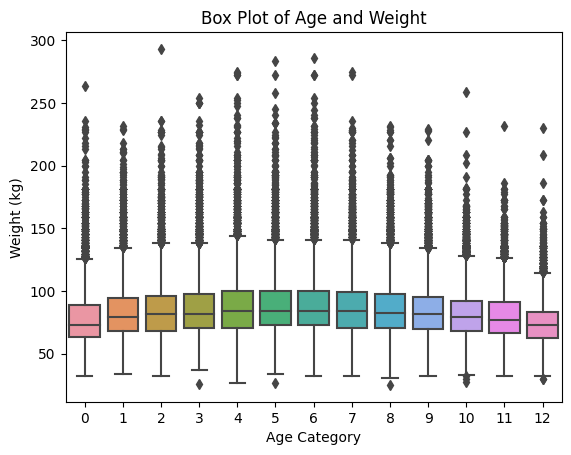

In [ ]:
# standard box plot of comparison between age and weight

sns.boxplot(x=BRFSS_2021['Age_Category'], y=BRFSS_2021['Weight_(kg)'])
plt.title('Box Plot of Age and Weight')
plt.xlabel('Age Category')
plt.ylabel('Weight (kg)')
plt.show()

In [ ]:
# interactive scatter plot showing BMI vs. age, color coding those that have been diagnosed with heart disease

BRFSS_2021_positive_diets = BRFSS_2021[BRFSS_2021['Diet'] > 0]

sampled_data = BRFSS_2021_positive_diets.sample(n=1000, random_state=42)

fig = px.scatter(sampled_data, x="BMI", y="Age_Category", color="Heart_Disease",
                 size="Diet", hover_name="General_Health",
                 labels={"Heart_Disease": "Has Heart Disease"},
                 title="Scatter Plot of BMI vs Age with Heart Disease Color Coding")

fig.update_layout(yaxis_title_text="Age Category", yaxis_title_standoff=20)

fig.show()

In [ ]:
# crosstabs for object columns to determine breakdowns of heart disease related to the certain features

categoricals = original.select_dtypes(include='object')

category_crosstabs = {}

for column in categoricals.columns:
    crosstab = pd.crosstab(index=original[column], columns=original['Heart_Disease'], margins=True, margins_name='Total')
    category_crosstabs[column] = crosstab

for column, crosstab in category_crosstabs.items():
    print(f"Crosstab for {column}:\n")

    table = PrettyTable()
    table.field_names = ["Category", "No Heart Disease", "Heart Disease", "Total"]

    for index, row in crosstab.iterrows():
        table.add_row([index, row[0], row[1], row['Total']])

    print(table)
    print("\n")


Crosstab for General_Health:

+-----------+------------------+---------------+--------+
|  Category | No Heart Disease | Heart Disease | Total  |
+-----------+------------------+---------------+--------+
| Excellent |      54839       |      1115     | 55954  |
|    Fair   |      29021       |      6789     | 35810  |
|    Good   |      86721       |      8643     | 95364  |
|    Poor   |       7729       |      3602     | 11331  |
| Very Good |      105573      |      4822     | 110395 |
|   Total   |      283883      |     24971     | 308854 |
+-----------+------------------+---------------+--------+


Crosstab for Checkup:

+-------------------------+------------------+---------------+--------+
|         Category        | No Heart Disease | Heart Disease | Total  |
+-------------------------+------------------+---------------+--------+
|   5 or more years ago   |      13079       |      342      | 13421  |
|          Never          |       1349       |       58      |  1407  |
| Wit

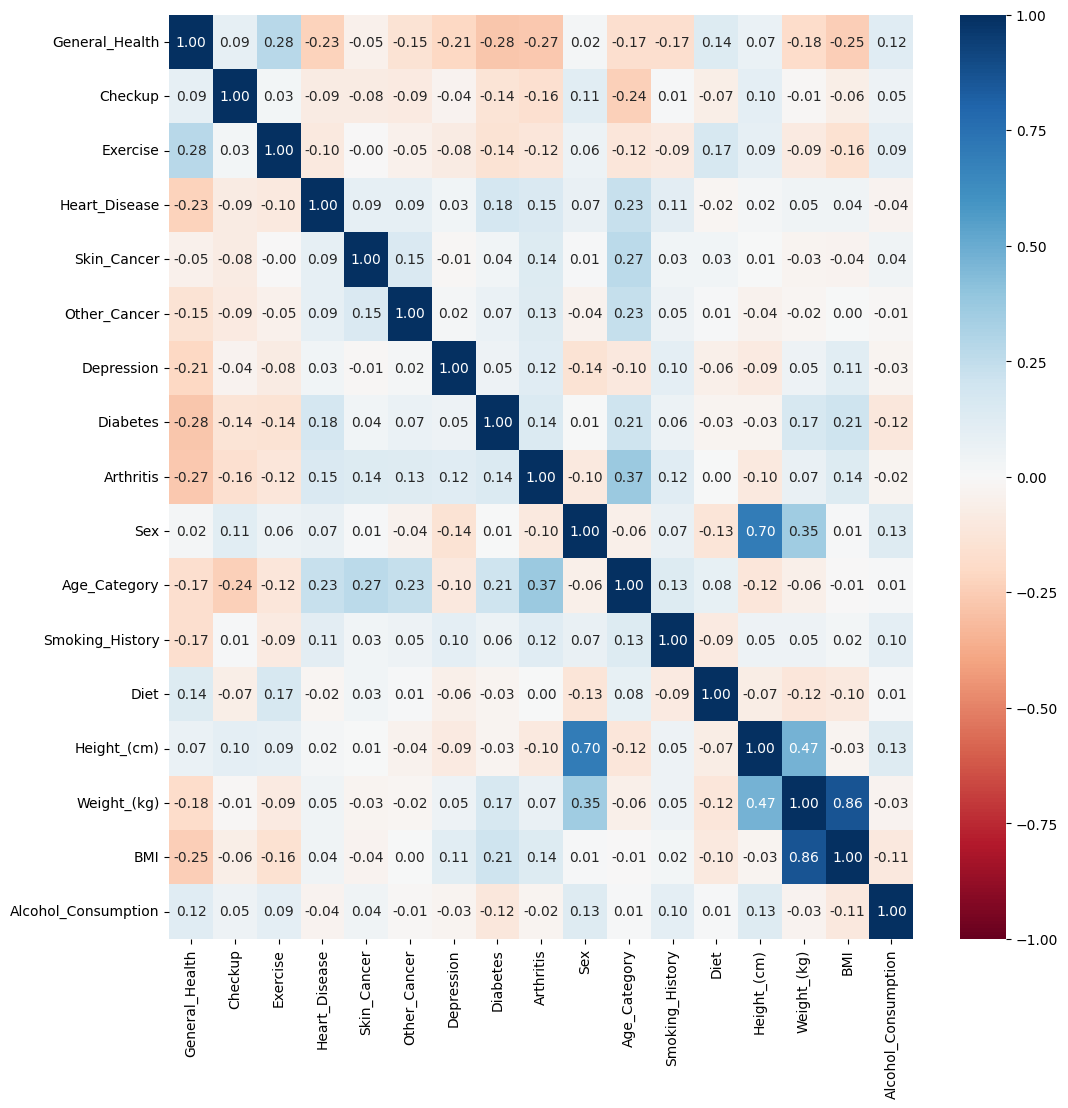

In [ ]:
# correlation heatmap
plt.figure(figsize=(12,12))
fig = sns.heatmap(data = BRFSS_2021.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, annot = True, fmt=".2f")
plt.show()

In [ ]:
BRFSS_2021_cleaned = BRFSS_2021.drop(columns={'Height_(cm)', 'Weight_(kg)'})

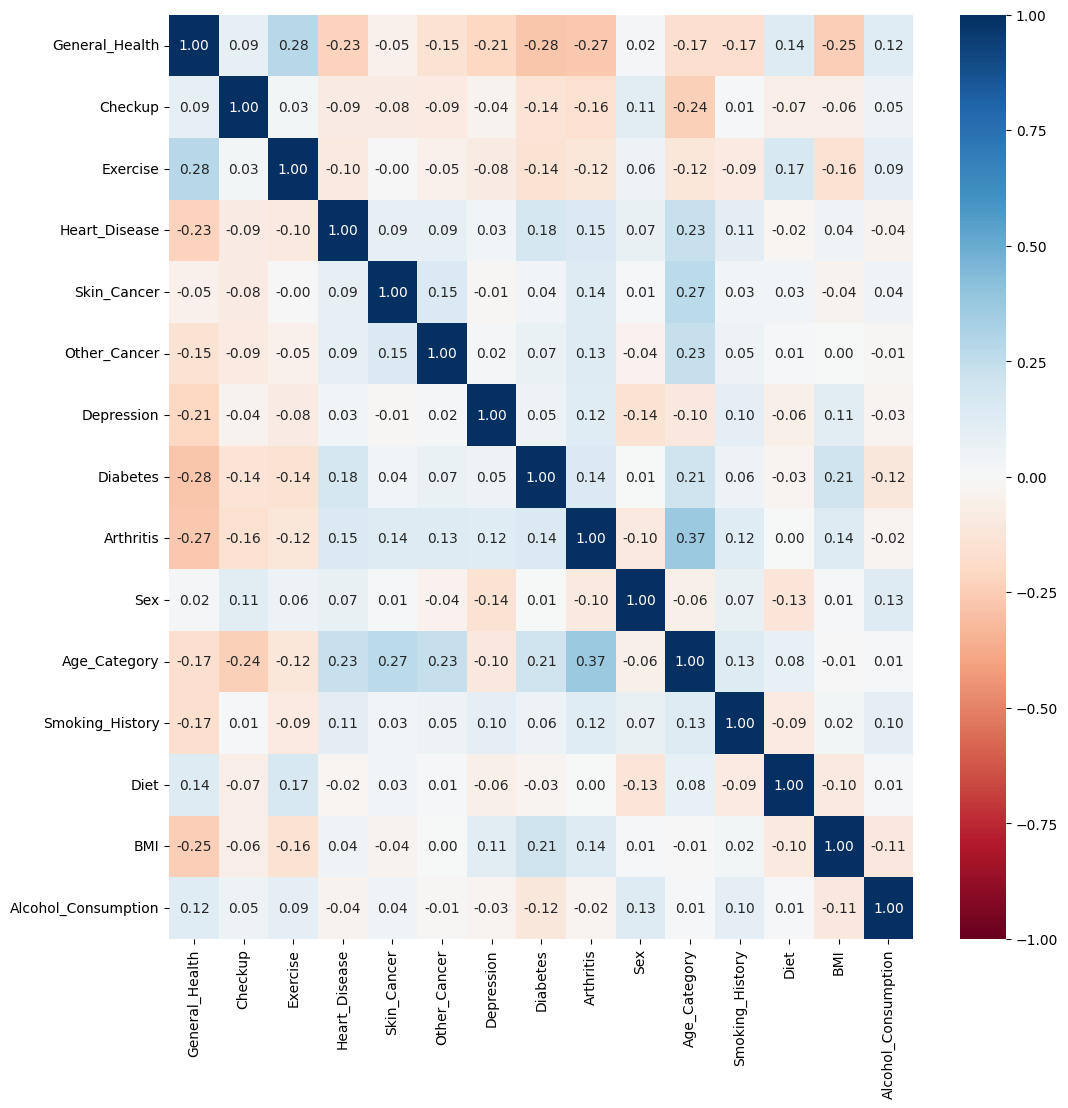

In [ ]:
# new correlation with cleaned data heatmap
plt.figure(figsize=(12,12))
fig = sns.heatmap(data = BRFSS_2021_cleaned.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, annot = True, fmt=".2f")
plt.show()

# Part 4: Modeling

##4.1 Creating Training and Testing Datasets

In [ ]:
#extract feature columns
features = BRFSS_2021_cleaned.drop(columns=["Heart_Disease"])

#extract target column
target = BRFSS_2021_cleaned["Heart_Disease"]

In [ ]:
#split into training and testing data
seed = 42
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=seed)

##4.2 Fitting Models Over Standard Data

###4.2.1 Baseline Logistic Regression Model

In [ ]:
# Create a pipeline with StandardScaler and logistic regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

# Define gridsearch parameters for tuning
param_grid_lr = {
    'logistic_regression__penalty': ['l1', 'l2', None],
    'logistic_regression__C': [0.1, 1],
    'logistic_regression__solver': ['saga']  # Both support 'l1'
}

# Initialize grid search with 5 folds for each candidate
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring="accuracy",verbose=1.1)

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

# Predict on the test set
y_pred_lr = grid_search_lr.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.5s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.2s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.8s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.4s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.2s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.6s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.9s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   0.9s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   0.9s
[CV] END logistic_regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



Best parameters for Logistic Regression: {'logistic_regression__C': 0.1, 'logistic_regression__penalty': None, 'logistic_regression__solver': 'saga'}
Best score for Logistic Regression: 0.919221475078712


In [ ]:
#Retrieve feature importance breakdowns
best_pipeline = grid_search_lr.best_estimator_
best_model = best_pipeline.named_steps['logistic_regression']
feature_importance = best_model.coef_[0]
feature_names = features.columns.tolist()
imp = zip(feature_names,feature_importance)
orderedImp = sorted(imp,key=lambda v: abs(v[1]), reverse=True)
for n,i in orderedImp:
  print(f"{n}: {i}")

Age_Category: 0.9762351548356653
General_Health: -0.5978687667480811
Sex: 0.39171409514014505
Smoking_History: 0.19174237243411163
Diabetes: 0.18141757809551393
Checkup: -0.16321462293534014
Arthritis: 0.12150337973134975
Depression: 0.1029813633223067
Alcohol_Consumption: -0.07655691474960999
Skin_Cancer: 0.02731695066612346
BMI: 0.017324844311261252
Exercise: -0.01362009596894238
Diet: 0.013289301433990793
Other_Cancer: 0.011827147334067083


###4.2.2 Logistic Regression Model with PCA

In [ ]:
# Create a pipeline with PCA and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

# Define the parameter grid
param_grid_pca = {
    'logistic_regression__penalty': ['l1', 'l2', None],
    'logistic_regression__C': [0.1, 1],
    'logistic_regression__solver': ['saga']
}

# Initialize the GridSearchCV object
grid_search_pca = GridSearchCV(pipeline, param_grid_pca, cv=5, scoring="accuracy",verbose=1.1)

# Fit the model
grid_search_pca.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for PCA Logistic Regression:", grid_search_pca.best_params_)
print("Best score for PCA Logistic Regression:", grid_search_pca.best_score_)

# Predict on the test set
y_pred_pca = grid_search_pca.predict(X_test)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   0.9s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.1s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   0.9s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.1s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   1.2s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   1.5s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   1.4s
[CV] END logistic_regression

###4.2.3 Random Forest Model

In [ ]:
# Define the parameter grid
param_grid_rf = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

# Initialize the GridSearchCV object
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy',verbose=1.1)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)

# Predict on the test set
y_pred_rf = grid_search_rf.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................max_depth=None, min_samples_split=2; total time=  19.2s
[CV] END ................max_depth=None, min_samples_split=2; total time=  20.7s
[CV] END ................max_depth=None, min_samples_split=2; total time=  19.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=  19.0s
[CV] END ................max_depth=None, min_samples_split=2; total time=  18.3s
[CV] END ................max_depth=None, min_samples_split=5; total time=  18.6s
[CV] END ................max_depth=None, min_samples_split=5; total time=  18.1s
[CV] END ................max_depth=None, min_samples_split=5; total time=  17.8s
[CV] END ................max_depth=None, min_samples_split=5; total time=  18.8s
[CV] END ................max_depth=None, min_samples_split=5; total time=  17.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  11.2s
[CV] END ..................max_depth=10, min_samp

In [ ]:
best_model = grid_search_rf.best_estimator_
feature_importance = best_model.feature_importances_
feature_names = features.columns.tolist()
imp = zip(feature_names,feature_importance)
orderedImp = sorted(imp,key=lambda v: abs(v[1]), reverse=True)
for n,i in orderedImp:
  print(f"{n}: {i}")

General_Health: 0.26346429335991056
Age_Category: 0.2550495052879347
Diabetes: 0.11361417002040182
Sex: 0.06416938060911626
BMI: 0.057660419256723716
Arthritis: 0.05309463833490951
Diet: 0.048909455534328294
Smoking_History: 0.03580370970691141
Alcohol_Consumption: 0.027843541529974085
Checkup: 0.023003764279530308
Skin_Cancer: 0.017621129779668652
Exercise: 0.016161248917810945
Other_Cancer: 0.013762765379985158
Depression: 0.00984197800279485


###4.2.4 KNN Model

In [ ]:
# Initialize the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5],  # Number of neighbors
}

# Initialize the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy',verbose=1.1)

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best score for KNN:", grid_search_knn.best_score_)

# Predict on the test set
y_pred_knn = grid_search_knn.predict(X_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................................n_neighbors=3; total time=   5.3s
[CV] END ......................................n_neighbors=3; total time=   5.7s
[CV] END ......................................n_neighbors=3; total time=   4.2s
[CV] END ......................................n_neighbors=3; total time=   4.5s
[CV] END ......................................n_neighbors=3; total time=   5.1s
[CV] END ......................................n_neighbors=5; total time=   4.7s
[CV] END ......................................n_neighbors=5; total time=   5.3s
[CV] END ......................................n_neighbors=5; total time=   4.7s
[CV] END ......................................n_neighbors=5; total time=   4.4s
[CV] END ......................................n_neighbors=5; total time=   5.7s
Best parameters for KNN: {'n_neighbors': 5}
Best score for KNN: 0.9117988682308011


###4.2.5 Summary of Model Performances

In [ ]:
confusion = confusion_matrix(y_test,y_pred_lr)
print("Confusion Matrix for Logistic Regression:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_lr)
print("Classification Report for Logistic Regression:")
print(classification_rep)
print()

confusion = confusion_matrix(y_test,y_pred_pca)
print("Confusion Matrix for Logistic Regression with PCA:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_pca)
print("Classification Report for Logistic Regression with PCA:")
print(classification_rep)
print()

confusion = confusion_matrix(y_test,y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_rf)
print("Classification Report for Random Forest:")
print(classification_rep)
print()

confusion = confusion_matrix(y_test,y_pred_knn)
print("Confusion Matrix for KNN:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_knn)
print("Classification Report for KNN:")
print(classification_rep)


Confusion Matrix for Logistic Regression:
[[56478   296]
 [ 4667   330]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56774
           1       0.53      0.07      0.12      4997

    accuracy                           0.92     61771
   macro avg       0.73      0.53      0.54     61771
weighted avg       0.89      0.92      0.89     61771


Confusion Matrix for Logistic Regression with PCA:
[[56558   216]
 [ 4784   213]]
Classification Report for Logistic Regression with PCA:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56774
           1       0.50      0.04      0.08      4997

    accuracy                           0.92     61771
   macro avg       0.71      0.52      0.52     61771
weighted avg       0.89      0.92      0.89     61771


Confusion Matrix for Random Forest:
[[56727    47]
 [ 4939    58]]
Classification Repo

#4.3 Fitting Models Over Synthetically-Enhanced Data

###4.3.1 Logistic Regression Model

In [ ]:
# Create a pipeline with StandardScaler and logistic regression
pipeline_lr = ImbPipeline([
    ('smote', SMOTE(random_state=seed)),
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=1000))
])


# Define the parameter grid for logistic regression
param_grid_lr = {
    'logistic_regression__penalty': ['l1', 'l2', None],
    'logistic_regression__C': [0.1, 1],
    'logistic_regression__solver': ['saga']  # Both support 'l1'
}

# Initialize the GridSearchCV object for the pipeline
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring="accuracy",verbose=1.1)

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

# Predict on the test set
y_pred_lr = grid_search_lr.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   3.1s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   3.4s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.7s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.9s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.9s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.8s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   3.1s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.8s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   4.0s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.5s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.8s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.9s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   3.7s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.9s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.7s
[CV] END logistic_regression

In [ ]:
best_pipeline = grid_search_lr.best_estimator_
best_model = best_pipeline.named_steps['logistic_regression']
feature_importance = best_model.coef_[0]
feature_names = features.columns.tolist()
imp = zip(feature_names,feature_importance)
orderedImp = sorted(imp,key=lambda v: abs(v[1]), reverse=True)
for n,i in orderedImp:
  print(f"{n}: {i}")

General_Health: -1.267852854687309
Age_Category: 0.9563555249542662
Checkup: -0.5116550877259518
Depression: -0.34021985479511097
Other_Cancer: -0.3149328028421996
Exercise: -0.2631201254158606
Skin_Cancer: -0.22531488436912314
Arthritis: -0.21745803432845762
Smoking_History: -0.1075814175370574
Diabetes: 0.09958010894064906
Sex: 0.08159169278444986
BMI: -0.043840064535837116
Alcohol_Consumption: 0.04244590002303554
Diet: 0.015156691693588926


###4.3.2 Logistic Regression Model with PCA

In [ ]:
# Create a pipeline with PCA and logistic regression
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=seed)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

# Define the parameter grid
param_grid_pca = {
    'logistic_regression__penalty': ['l1', 'l2', None],
    'logistic_regression__C': [0.1, 1],
    'logistic_regression__solver': ['saga']
}

# Initialize the GridSearchCV object
grid_search_pca = GridSearchCV(pipeline, param_grid_pca, cv=5, scoring="accuracy",verbose=1.1)

# Fit the model
grid_search_pca.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for PCA Logistic Regression:", grid_search_pca.best_params_)
print("Best score for PCA Logistic Regression:", grid_search_pca.best_score_)

# Predict on the test set
y_pred_pca = grid_search_pca.predict(X_test)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.5s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.3s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   3.4s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.7s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.6s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.6s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.3s
[CV] END logistic_regression__C=0.1, logistic_regression__penalty=l2, logistic_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



[CV] END logistic_regression__C=0.1, logistic_regression__penalty=None, logistic_regression__solver=saga; total time=   2.8s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.4s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.6s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   3.3s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.9s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l1, logistic_regression__solver=saga; total time=   2.5s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.4s
[CV] END logistic_regression__C=1, logistic_regression__penalty=l2, logistic_regression__solver=saga; total time=   2.6s
[CV] END logistic_regression

###4.3.3 Random Forest Model

In [ ]:
# Define the parameter grid
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=seed)),
    ('random_forest', RandomForestClassifier())
])

param_grid_rf = {
    'random_forest__max_depth': [None, 10],
    'random_forest__min_samples_split': [2, 5]
}

# Initialize the GridSearchCV object
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy',verbose=1.1)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)

# Predict on the test set
y_pred_rf = grid_search_rf.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=2; total time=  44.9s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=2; total time=  44.8s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=2; total time=  44.8s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=2; total time=  45.2s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=2; total time=  45.8s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=5; total time=  45.0s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=5; total time=  44.9s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=5; total time=  45.0s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=5; total time=  45.2s
[CV] END random_forest__max_depth=None, random_forest__min_samples_split=5; total tim

In [ ]:
best_pipeline = grid_search_rf.best_estimator_
best_model = best_pipeline.named_steps['random_forest']
feature_importance = best_model.feature_importances_
feature_names = features.columns.tolist()
imp = zip(feature_names,feature_importance)
orderedImp = sorted(imp,key=lambda v: abs(v[1]), reverse=True)
for n,i in orderedImp:
  print(f"{n}: {i}")

BMI: 0.19615404727767424
Diet: 0.18385711194634585
General_Health: 0.1765836805596882
Age_Category: 0.15380799157203345
Alcohol_Consumption: 0.09979016804803063
Checkup: 0.04453223128061185
Exercise: 0.041198035217159416
Diabetes: 0.02563669016945788
Depression: 0.019893882823599617
Other_Cancer: 0.012681124225619672
Sex: 0.012535602304189068
Smoking_History: 0.012436133395906428
Arthritis: 0.01228728666476425
Skin_Cancer: 0.00860601451491936


###4.3.4 KNN Model

In [ ]:
pipeline_knn = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for KNN
param_grid_knn = {
    'knn__n_neighbors': [3, 5],  # Number of neighbors
}

# Initialize the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy',verbose=1.1)

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best score for KNN:", grid_search_knn.best_score_)

# Predict on the test set
y_pred_knn = grid_search_knn.predict(X_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................knn__n_neighbors=3; total time=   6.9s
[CV] END .................................knn__n_neighbors=3; total time=   8.5s
[CV] END .................................knn__n_neighbors=3; total time=   7.5s
[CV] END .................................knn__n_neighbors=3; total time=   8.0s
[CV] END .................................knn__n_neighbors=3; total time=   7.8s
[CV] END .................................knn__n_neighbors=5; total time=   7.6s
[CV] END .................................knn__n_neighbors=5; total time=   8.6s
[CV] END .................................knn__n_neighbors=5; total time=   7.7s
[CV] END .................................knn__n_neighbors=5; total time=   8.8s
[CV] END .................................knn__n_neighbors=5; total time=   9.0s
Best parameters for KNN: {'knn__n_neighbors': 3}
Best score for KNN: 0.7666694872345923


###4.3.5 Summary of Model Performances Utilizing SMOTE

In [ ]:
confusion = confusion_matrix(y_test,y_pred_lr)
print("Confusion Matrix for Logistic Regression:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_lr)
print("Classification Report for Logistic Regression:")
print(classification_rep)
print()

confusion = confusion_matrix(y_test,y_pred_pca)
print("Confusion Matrix for Logistic Regression with PCA:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_pca)
print("Classification Report for Logistic Regression with PCA:")
print(classification_rep)
print()

confusion = confusion_matrix(y_test,y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_rf)
print("Classification Report for Random Forest:")
print(classification_rep)
print()

confusion = confusion_matrix(y_test,y_pred_knn)
print("Confusion Matrix for KNN:")
print(confusion)
classification_rep = classification_report(y_test, y_pred_knn)
print("Classification Report for KNN:")
print(classification_rep)


Confusion Matrix for Logistic Regression:
[[44414 12360]
 [ 1923  3074]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     56774
           1       0.20      0.62      0.30      4997

    accuracy                           0.77     61771
   macro avg       0.58      0.70      0.58     61771
weighted avg       0.90      0.77      0.82     61771


Confusion Matrix for Logistic Regression with PCA:
[[43323 13451]
 [ 1975  3022]]
Classification Report for Logistic Regression with PCA:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56774
           1       0.18      0.60      0.28      4997

    accuracy                           0.75     61771
   macro avg       0.57      0.68      0.57     61771
weighted avg       0.89      0.75      0.80     61771


Confusion Matrix for Random Forest:
[[50903  5871]
 [ 3352  1645]]
Classification Repo

# Part 5: Conclusion

Upon completing the modeling section, I have been able to make various takeaways from this project.


*   I first noticed that there exists a class imbalance in the data that has led to seeing a relatively high accuracy without identifying actually positive cases, leading therefore to a very low recall. However, once attempting to solve this issue through the usage of SMOTE, it was evident that despite a significant improvement in recall of true positive heart disease diagnoses, there also came a significantly increased number of false positives, thus bringing the accuracy of the models down.
*   Overall, this led me to conclude that working with this dataset proved very challenging to predict disese risk, meaning it may have required more specific features that could directly determine whether one is at risk for heart disese.

In the future, there are various things I'd reconsider when approaching this project.


*   I would first attempt to explore additional features that could enhance the prediction model itself, given the inaccuracies resulting from the current features.
*   Next, I would potentially consider integrating various other external datasets apart from strictly health-related issues, which may include but not be limited to environmental data and socioeconomic indicators of poor cardiovascular health.
*   Finally, I'd consider implementing a time-series analysis of data specifically on the lifestyle factors in order to capture specific trends or other temporal patterns contributing to either a positive or negative test of cardiovascular disease.

Thank you so much for reading through the project!





